In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
activity_header = ['id', 'subject_id', 'session', 'start_time', 'end_time',
                   'rel_start_time', 'rel_end_time', 'gesture_scenario', 'task_id', 'content_id']

accelerometer_header = ['sys_time', 'event_time', 'activity_id', 'x', 'y', 'z', 'orientation']

gyroscope_header = accelerometer_header.copy()
magnetometer_header = accelerometer_header.copy()

touch_event_header = ['sys_time', 'event_time', 'activity_id', 'pointer_count', 'pointer_id',
                      'action_id', 'x', 'y', 'pressure', 'contact_size', 'orientation']

# activity_id and press_type should be swapped, there is a typo in dataset description
# it also seems that press_type should be reversed (1: finger down, 0: finger up)
key_press_event_header = ['sys_time', 'press_time', 'activity_id', 'press_type', 'key_id', 'orientation']

one_finger_touch_event_header = ['sys_time', 'press_time', 'activity_id', 'tap_id', 'tap_type', 'action_type',
                                 'x', 'y', 'pressure', 'contact_size', 'orientation']

pinch_event_header = ['sys_time', 'press_time', 'activity_id', 'event_type', 'pinch_id', 'time_delta',
                      'x_focus', 'y_focus', 'span', 'span_x', 'span_y', 'scale_factor', 'orientation']

scroll_event_header = ['sys_time', 'begin_time', 'current_time', 'activity_id', 'scroll_id', 'start_action_type',
                       'start_x', 'start_y', 'start_pressure', 'start_size', 'current_action_type',
                       'current_x', 'current_y', 'current_pressure', 'current_size', 'distance_x', 'distance_y',
                       'orientation']

stroke_event_header = ['sys_time', 'begin_time', 'end_time', 'activity_id', 'start_action_type', 'start_x', 'start_y',
                       'start_pressure', 'start_size', 'end_action_type', 'end_x', 'end_y', 'end_pressure', 'end_size',
                       'speed_x', 'speed_y', 'orientation']

In [3]:
import os

dataset_path = 'hmog_public_dataset/'

# These are just for tests
subject_1_path = os.path.join(dataset_path, '100669')
subject_2_path = os.path.join(dataset_path, '151985')

## Data Preprocessing

I think it's worth creating helper functions that read given paths, preprocess, and combine the data

In [7]:
import os

def check_session_typing(path_to_session: str):
    # We are interested in sessions 3, 9, 15, 21 for w+s
    # and 4, 10, 16, 22 for w+w
    typing_task_ids = [3, 9, 15, 21, 4, 10, 16, 22]

    return check_session_type(path_to_session, typing_task_ids)

def check_session_type(path_to_session: str, type_ids: list):
    activity_df = pd.read_csv(os.path.join(path_to_session, 'Activity.csv'), names=activity_header)

    if activity_df['task_id'][0] in type_ids:
        return True
    return False

def filter_user_sessions_by_type(path_to_sessions: str, type_ids: list):
    session_folders = os.listdir(path_to_sessions)
    session_folders = [f for f in session_folders if not os.path.isfile(os.path.join(path_to_sessions, f))]

    typing_session_folders = []
    for session_folder in session_folders:
        if check_session_type(os.path.join(path_to_sessions, session_folder), type_ids):
            typing_session_folders.append(session_folder)

    return typing_session_folders

def check_session_orientation(path_to_session: str, is_portrait: bool):
    ORIENTATION_PORTRAIT = 0

    accelerometer_df = pd.read_csv(os.path.join(path_to_session, 'Accelerometer.csv'), names=accelerometer_header)

    for _, data in accelerometer_df.iterrows():
        if is_portrait:
            if data['orientation'] == ORIENTATION_PORTRAIT:
                return True
            return False
        else:
            if data['orientation'] != ORIENTATION_PORTRAIT:
                return True
            return False

def filter_user_sessions_by_orientation(path_to_sessions: str, is_portrait: bool):
    session_folders = os.listdir(path_to_sessions)
    session_folders = [f for f in session_folders if not os.path.isfile(os.path.join(path_to_sessions, f))]

    sessions = []
    for session_folder in session_folders:
        if check_session_orientation(os.path.join(path_to_sessions, session_folder), is_portrait):
            sessions.append(session_folder)

    return sessions

def list_folder(path_to_dataset: str):
    folders = os.listdir(path_to_dataset)
    folders = [f for f in folders if not os.path.isfile(os.path.join(path_to_dataset, f))]

    return folders

In [12]:
ww_session_types = [4, 10, 16, 22]
ws_session_types = [3, 9, 15, 21]

# subject_1_ww_sessions = filter_user_sessions_by_type(subject_1_path, ww_session_types)
# subject_2_ww_sessions = filter_user_sessions_by_type(subject_2_path, ww_session_types)

In [14]:
subjects = list_folder(dataset_path)

landscape_ww_sessions = []
for subject in subjects:
    subject_landscape_sessions = filter_user_sessions_by_orientation(os.path.join(dataset_path, subject), False)
    subject_landscape_ww_sessions = []
    for session in subject_landscape_sessions:
        if check_session_type(os.path.join(dataset_path, subject, session), ww_session_types):
            subject_landscape_ww_sessions.append(session)
    if len(subject_landscape_ww_sessions) > 0:
        landscape_ww_sessions.append(subject_landscape_ww_sessions)

In [15]:
landscape_ww_sessions

[['856302_session_21'],
 ['751131_session_24'],
 ['220962_session_6', '220962_session_15'],
 ['186676_session_1'],
 ['980953_session_4'],
 ['201848_session_22'],
 ['675397_session_1']]

In [6]:
print(subject_1_ww_sessions)
print(subject_2_ww_sessions)

['100669_session_22', '100669_session_24', '100669_session_19', '100669_session_9']
['151985_session_24', '151985_session_7', '151985_session_8', '151985_session_21']


In [9]:
import os
import pandas as pd
import numpy as np

def read_person_session(path_to_session: str):
    activity_csv = pd.read_csv(os.path.join(path_to_session, 'Activity.csv'), names=activity_header)
    accelerometer_csv = pd.read_csv(os.path.join(path_to_session, 'Accelerometer.csv'), names=accelerometer_header)
    gyroscope_csv = pd.read_csv(os.path.join(path_to_session, 'Gyroscope.csv'), names=gyroscope_header)
    key_press_event_csv = pd.read_csv(os.path.join(path_to_session, 'KeyPressEvent.csv'), names=key_press_event_header)
    magnetometer_csv = pd.read_csv(os.path.join(path_to_session, 'Magnetometer.csv'), names=magnetometer_header)
    one_finger_touch_csv = pd.read_csv(os.path.join(path_to_session, 'OneFingerTouchEvent.csv'), names=one_finger_touch_event_header)
    pinch_event_csv = pd.read_csv(os.path.join(path_to_session, 'PinchEvent.csv'), names=pinch_event_header)
    scroll_event_csv = pd.read_csv(os.path.join(path_to_session, 'ScrollEvent.csv'), names=scroll_event_header)
    stroke_event_csv = pd.read_csv(os.path.join(path_to_session, 'StrokeEvent.csv'), names=stroke_event_header)
    touch_event_csv = pd.read_csv(os.path.join(path_to_session, 'TouchEvent.csv'), names=touch_event_header)

    session_map = {"activity": activity_csv,
                   "accelerometer": accelerometer_csv,
                   "gyroscope": gyroscope_csv,
                   "key_press_event": key_press_event_csv,
                   "magnetometer": magnetometer_csv,
                   "one_finger_touch": one_finger_touch_csv,
                   "pinch_event": pinch_event_csv,
                   "scroll_event": scroll_event_csv,
                   "stroke_event": stroke_event_csv,
                   "touch_event": touch_event_csv}
    
    return session_map

def add_M(sensor_data):
    sensor_data['M'] = (sensor_data['x'] ** 2 + sensor_data['y'] ** 2 + sensor_data['z'] ** 2) ** 0.5

def preprocess_session_data(session_map: dict):
    # Let's add M = sqrt(x^2 + y^2 + z^2) column to every sensor
    add_M(session_map['accelerometer'])
    add_M(session_map['gyroscope'])
    add_M(session_map['magnetometer'])

def compute_t_min(sensor_data, value_of: str, t_end_timestamp: int, avg100msBefore: float):
    TIME_AFTER_END_OFFSET = 200  # ms

    sensor_data = sensor_data[(sensor_data['sys_time'] >= t_end_timestamp) & (sensor_data['sys_time'] <= t_end_timestamp + TIME_AFTER_END_OFFSET)]

    n = len(sensor_data.index)
    avgDiffs = np.empty(n)
    sums = np.zeros(n)

    # Indices are not updated after taking a slice of a dataframe!
    sums[n - 1] = abs(sensor_data.iloc[n - 1][value_of] - avg100msBefore)
    for index, entry in sensor_data.iloc[-2::-1].iterrows():
        index = index - sensor_data.index[0]  # TODO: optimize?

        sums[index] = abs(entry[value_of] - avg100msBefore) + sums[index + 1]
    
    min_index = 0
    min_val = 10000000
    for i in range(n):
        avgDiffs[i] = sums[i] / (n - i)

        if avgDiffs[i] < min_val:
            min_val = avgDiffs[i]
            min_index = i
            # print(f'min_index, min_val: {min_index}, {min_val}')

    min_index = np.argmin(avgDiffs)
    return sensor_data.iloc[min_index]['sys_time']

def extract_hmog_for_keypress(sensor_data, key_down_timestamp: int, key_up_timestamp: int, value_of: str):
    zero_comparison_epsilon = 0.000001

    TIME_BEFORE_BOUNDARY = 100  # ms
    TIME_AFTER_BOUNDARY = 100   # ms
    TIME_AFTER_FOR_T_MIN = 200  # ms

    t_max = -1
    max_during = -10000000000

    vals_before = []
    vals_during = []
    vals_after = []

    sensor_data = sensor_data[(sensor_data['sys_time'] >= (key_down_timestamp - TIME_BEFORE_BOUNDARY)) & (sensor_data['sys_time'] <= (key_up_timestamp + TIME_AFTER_FOR_T_MIN))]

    for _, entry in sensor_data.iterrows():
        if entry['sys_time'] >= (key_down_timestamp - TIME_BEFORE_BOUNDARY) and entry['sys_time'] < key_down_timestamp:
            vals_before.append(entry[value_of])
        elif entry['sys_time'] >= key_down_timestamp and entry['sys_time'] <= key_up_timestamp:
            vals_during.append(entry[value_of])
            if entry[value_of] > max_during:
                max_during = entry[value_of]
                t_max = entry['sys_time']
        elif entry['sys_time'] > key_up_timestamp and entry['sys_time'] <= (key_up_timestamp + TIME_AFTER_BOUNDARY):
            vals_after.append(entry[value_of])
    
    # vals_* might be empty, which will result in division by zero, and, consequently, incorrect hmog features
    # We could eg. try appending the last value of vals_before to vals_during in case len(vals_during) == 0,
    # however, for now I suppose it's better to totally reject such keypresses

    if len(vals_before) == 0 or len(vals_during) == 0 or len(vals_after) == 0:
        return (False, []) 

    # HMOG features
    #
    # "Grasp Resistance"
    # 1. Mean during taps
    mean_during = sum(vals_during) / len(vals_during)
    # 2. Standard deviation during taps
    std_deviation_during = ( sum([(x - mean_during) ** 2 for x in vals_during]) / len(vals_during) ) ** 0.5
    # 3. avg100msAfter - avg100msBefore
    avg100msAfter = sum(vals_after) / len(vals_after)
    avg100msBefore = sum(vals_before) / len(vals_before)
    # print(f'avg100msBefore: {avg100msBefore}')

    diff_readings = avg100msAfter - avg100msBefore

    # 4. avgTap - avg100msBefore
    net_change = mean_during - avg100msBefore
    # 5. max change during tap
    max_change_during = max_during - avg100msBefore

    #
    # "Grasp Stability"
    # 1
    t_min = compute_t_min(sensor_data, value_of, key_up_timestamp, avg100msBefore)
    time_to_stabilize = t_min - key_up_timestamp

    # 2
    t_after_center = key_up_timestamp + 50     # ms
    t_before_center = key_down_timestamp - 50  # ms
    d_duration = (t_after_center - t_before_center) / (avg100msAfter - avg100msBefore)
    # TODO: temporary solution, fix
    if (avg100msAfter - avg100msBefore < zero_comparison_epsilon):
        d_duration = 0

    # 3
    d_max_to_avg = (t_after_center - t_max) / (avg100msAfter - max_during)
    # TODO: temporary solution, fix
    if (avg100msAfter - max_during < zero_comparison_epsilon):
        d_max_to_avg = 0

    return (True, [mean_during, std_deviation_during, diff_readings, net_change, max_change_during,
            time_to_stabilize, d_duration, d_max_to_avg])

sensor_list = ['accelerometer', 'gyroscope']
dims_list = ['x', 'y', 'z', 'M']
hmog_features_len = len(sensor_list) * len(dims_list) * 8
# This can be optimised, for now this is coded to present everything as simple as possible
# value_of: x, y, z, M
# TODO: use sensor_list and dims so that we don't iterate over the whole dataset many times
def extract_hmog_features(session_map: dict, sensor_list: list, dims_list: list):
    # "Grasp Resistance" features

    PRESS_TYPE_DOWN = 1
    PRESS_TYPE_UP = 0

    hmog_vectors = []
    key_down_timestamps = []

    for key_press_event_index in range(len(session_map['key_press_event']) - 1):
        event = session_map['key_press_event'].iloc[key_press_event_index]
        event_down_time = event['sys_time']

        if event['press_type'] == PRESS_TYPE_DOWN:
            next_event = session_map['key_press_event'].iloc[key_press_event_index + 1]

            # Let's focus on cases when user lifts the finger before pressing another key
            if next_event['press_type'] != PRESS_TYPE_UP:
                continue
            
            event_up_time = next_event['sys_time']

            curr_key_press_hmog_vectors = []

            key_press_hmog_ext_success = True
            for sensor in sensor_list:
                for dim in dims_list:
                    extraction_result, tap_hmog_vector = extract_hmog_for_keypress(session_map[sensor], event_down_time,
                                                                                     event_up_time, dim)
                    if extraction_result:
                        curr_key_press_hmog_vectors.append(tap_hmog_vector)
                    else:
                        key_press_hmog_ext_success = False
                        break
                
                if not key_press_hmog_ext_success:
                    break
            
            if key_press_hmog_ext_success:
                key_down_timestamps.append([event_down_time])
                hmog_vectors.append(curr_key_press_hmog_vectors)

    hmog_vectors_numpy = np.array(hmog_vectors).reshape(-1, hmog_features_len)
    hmog_vectors_numpy = np.concatenate((key_down_timestamps, hmog_vectors_numpy), axis=1)
    return hmog_vectors_numpy

In [22]:
session_map = read_person_session(os.path.join(subject_1_path, subject_1_ww_sessions[0]))
session_map_2 = read_person_session(os.path.join(subject_1_path, subject_1_ww_sessions[1]))
preprocess_session_data(session_map)
preprocess_session_data(session_map_2)

# Extracting and combining feature vectors

In [10]:
# We also need to scale obtained vectors

def calc_std_and_scale(user_session_matrix):
    # matrix: (n_samples, n_features)

    # (1, n_features)
    std_deviations_features = np.std(user_session_matrix, axis=0, dtype=np.float64)

    return std_deviations_features, scale_by(user_session_matrix, std_deviations_features)

def scale_by(user_session_matrix, std_deviation_vector):
    assert std_deviation_vector.shape[0] == user_session_matrix.shape[1]

    result = np.zeros_like(user_session_matrix, dtype=np.float64)

    for i in range(user_session_matrix.shape[1]):
        result[:, i] = user_session_matrix[:, i] / std_deviation_vector[i]

    return result

In [ ]:
session_hmog_vector = extract_hmog_features(session_map, sensor_list, dims_list)
session_hmog_vector_2 = extract_hmog_features(session_map_2, sensor_list, dims_list)

session_hmog_vector = np.vstack((session_hmog_vector, session_hmog_vector_2))

std_deviations, session_hmog_vector = calc_std_and_scale(session_hmog_vector)

In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.model_selection import GridSearchCV

param_grid = {
    'nu': [0.01, 0.03, 0.05, 0.1, 0.15, 0.5],
    'kernel': ['rbf'],
    'gamma': [2 ** -13, 2 ** -11, 2 ** -9, 2 ** -7, 2 ** -5, 2 ** -3, 2 ** -1, 2, 2 ** 3, 2 ** 5, 2 ** 7, 2 ** 9, 2 ** 11, 2 ** 13],
    # 'gamma': ['auto']
}

svm = OneClassSVM()

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=10, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(session_hmog_vector)

print("Best Parameters:", grid_search.best_params_)


In [44]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'gamma': 0.0001220703125, 'kernel': 'rbf', 'nu': 0.01}


In [46]:
print("The model was fitted on subject_1, w+w session type")
print("Let's see what accuracies it shows (correctly_predicted_taps / all_taps)")

for session in subject_1_ww_sessions:
    session_map = read_person_session(os.path.join(subject_1_path, session))
    preprocess_session_data(session_map)

    session_hmog_vector = extract_hmog_features(session_map, sensor_list, dims_list)

    session_hmog_vector = scale_by(session_hmog_vector, std_deviations)
    curr_accuracy = test_hmog(session_hmog_vector, 1, grid_search)

    print(curr_accuracy)

The model was fitted on subject_1, w+w session type
Let's see what accuracies it shows (correctly_predicted_taps / all_taps)
0.990487514863258
0.990909090909091
0.9893238434163701
0.9875565610859729


We can see that the model recognizes the owner even in other sessions (in sessions the model did not see before)

Now let's see what happens when we test the model against sessions of the same type (writing + walking), but belonging to another subject.

In [47]:
print("The model was fitted on subject_1, w+w session type")
print("This time we test it against another subject, so the confidence of the model is calculated as (incorrectly_predicted_taps / all_taps)")

for session in subject_2_ww_sessions:
    session_map = read_person_session(os.path.join(subject_2_path, session))
    preprocess_session_data(session_map)

    session_hmog_vector = scale_by(extract_hmog_features(session_map, sensor_list, dims_list), std_deviations)
    curr_accuracy = test_hmog(session_hmog_vector, 1, grid_search)

    print(curr_accuracy)

The model was fitted on subject_1, w+w session type
This time we test it against another subject, so the confidence of the model is calculated as (incorrectly_predicted_taps / all_taps)
0.9789473684210527
0.9878542510121457
0.9873817034700315
0.9675036927621861


Alright, we can see that the model is capable of distinguishing these two subjects. Now let's test the model against all other subjects in the dataset

In [ ]:
from tqdm import tqdm

def test_model_on_dataset(session_types):
    subjects_dirs = list_folder(dataset_path)

    false_positive_sum = 0
    total_test_sessions_count = 0
    avg_false_positive = 0

    curr_subject_index = 0
    # We fit the model with one subject (using a single session only) and test against all other subjects
    # We do it for each subject and calculate average
    for curr_subject in tqdm(subjects_dirs):

        subject_sessions = filter_user_sessions_by_type(os.path.join(dataset_path, curr_subject), session_types)
        session_map = read_person_session(os.path.join(dataset_path, curr_subject, subject_sessions[0]))
        preprocess_session_data(session_map)

        session_matrix = extract_hmog_features(session_map, sensor_list, dims_list)

        std_deviations, session_hmog_vector = calc_std_and_scale(session_matrix)

        svm = OneClassSVM(kernel='rbf', gamma=grid_search.best_params_['gamma'], nu=grid_search.best_params_['nu']).fit(session_hmog_vector)

        # Let's test it against all other subjects and calculate average accuracy
        other_subjects = subjects_dirs.copy()
        del other_subjects[curr_subject_index]

        for another_subject in other_subjects:
            test_subject_sessions = filter_user_sessions_by_type(os.path.join(dataset_path, another_subject), ww_session_types)


            for test_session in test_subject_sessions:
                test_session_map = read_person_session(os.path.join(dataset_path, another_subject, test_session))
                preprocess_session_data(test_session_map)

                test_session_matrix = extract_hmog_features(test_session_map, sensor_list, dims_list)

                test_session_hmog_vector = scale_by(test_session_matrix, std_deviations)

                curr_false_positive_ratio = test_hmog(test_session_hmog_vector, 1, svm)
                false_positive_sum += curr_false_positive_ratio
                total_test_sessions_count += 1

                avg_false_positive = false_positive_sum / total_test_sessions_count

                # print(f'session {test_session} false pos: {curr_false_positive_ratio}')

            print(f'Current tested session count: {total_test_sessions_count}\navg_false_positive: {avg_false_positive}')
        curr_subject_index += 1

test_model_on_dataset(session_types=ww_session_types)   

# Visualisations

t_min: 1400545748153.0


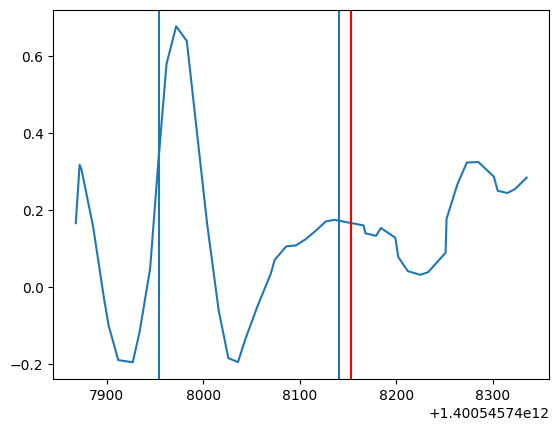

In [ ]:
# Some visualisations

PRESS_TYPE_DOWN = 1
PRESS_TYPE_UP = 0

TIME_BEFORE_OFFSET = 100  # ms
TIME_AFTER_OFFSET  = 200  # ms

test_sensor = 'gyroscope'
test_value = 'x'

hmog_vectors = []
for key_press_event_index in range(len(session_map['key_press_event']) - 1):
    event = session_map['key_press_event'].iloc[key_press_event_index]
    event_down_time = event['sys_time']

    if event['press_type'] == PRESS_TYPE_DOWN:
        next_event = session_map['key_press_event'].iloc[key_press_event_index + 1]

        # Let's focus on cases when user lifts the finger before pressing another key
        if next_event['press_type'] != PRESS_TYPE_UP:
            continue
        
        event_up_time = next_event['sys_time']
        tap_hmog_vector_x = extract_hmog_for_keypress(session_map[test_sensor], event_down_time, event_up_time, test_value)

        hmog_vectors.append(tap_hmog_vector_x)

        timeframe = session_map[test_sensor][(session_map[test_sensor]['sys_time'] >= event_down_time - TIME_BEFORE_OFFSET) & (session_map[test_sensor]['sys_time'] <= event_up_time + 200)]
        t_min = compute_t_min(session_map[test_sensor], test_value, event_up_time, 0.0519235415)
        print(f't_min: {t_min}')
        fig = plt.figure()
        ax = plt.axes()
        ax.plot(timeframe['sys_time'], timeframe[test_value])
        ax.axvline(x=t_min, color='red')
        ax.axvline(x=event_down_time)
        ax.axvline(x=event_up_time)

        break

In [ ]:
session_map['accelerometer'][:10]

,sys_time,event_time,activity_id,x,y,z,orientation,M
0,1400545737742,1853505875000,151985081000001,-0.596156,3.095104,8.168418,0,8.755463
1,1400545737744,1853513352000,151985081000001,-0.587777,3.207632,8.182184,0,8.808094
2,1400545737770,1853523362000,151985081000001,-0.594959,3.251326,8.239645,0,8.877885
3,1400545737773,1853533372000,151985081000001,-0.599748,3.306991,8.189965,0,8.852763
4,1400545737775,1853543381000,151985081000001,-0.916979,3.362656,8.243835,0,8.950370
5,1400545737781,1853553391000,151985081000001,-0.574010,3.306991,8.019379,0,8.693452
6,1400545737830,1853563401000,151985081000001,-0.288501,3.527856,7.726089,0,8.498321
7,1400545737834,1853573411000,151985081000001,-0.474052,3.670311,7.921216,0,8.743088
8,1400545737837,1853583421000,151985081000001,-0.490811,3.669114,7.978677,0,8.795600
9,1400545737839,1853593400000,151985081000001,-0.558448,3.678691,8.287529,0,9.084480


In [ ]:
some_df = pd.DataFrame([5, 1, 3, 4, 7, 2])
print(some_df)

another_df = some_df[some_df[0] % 2 == 0]
print(another_df)

print(another_df.index[0])

   0
0  5
1  1
2  3
3  4
4  7
5  2
   0
3  4
5  2
3


In [13]:
def get_session_info(session_map: dict, sensor_list: list, dims_list: list):
    PRESS_TYPE_DOWN = 1
    PRESS_TYPE_UP = 0

    hmog_vectors = []
    key_down_timestamps = []

    for key_press_event_index in range(len(session_map['key_press_event']) - 1):
        event = session_map['key_press_event'].iloc[key_press_event_index]
        event_down_time = event['sys_time']

        if event['press_type'] == PRESS_TYPE_DOWN:
            next_event = session_map['key_press_event'].iloc[key_press_event_index + 1]

            # Let's focus on cases when user lifts the finger before pressing another key
            if next_event['press_type'] != PRESS_TYPE_UP:
                continue
            
            event_up_time = next_event['sys_time']

            curr_key_press_hmog_vectors = []

            key_press_hmog_ext_success = True
            for sensor in sensor_list:
                for dim in dims_list:
                    extraction_result, tap_hmog_vector = extract_hmog_for_keypress(session_map[sensor], event_down_time,
                                                                                     event_up_time, dim)
                    if extraction_result:
                        curr_key_press_hmog_vectors.append(tap_hmog_vector)
                    else:
                        key_press_hmog_ext_success = False
                        break
                
                if not key_press_hmog_ext_success:
                    break
            
            if key_press_hmog_ext_success:
                key_down_timestamps.append([event_down_time])
                hmog_vectors.append(curr_key_press_hmog_vectors)

    return (np.array(key_down_timestamps).shape, np.array(hmog_vectors))

In [15]:
from tqdm import tqdm

def get_dataset_info(session_types):
    dataset_info = {"key_down_timestamp.shapes": [],
                    "hmog_vectors.shapes": []}

    subjects_dirs = list_folder(dataset_path)
    for curr_subject in tqdm(subjects_dirs):

        subject_sessions = filter_user_sessions_by_type(os.path.join(dataset_path, curr_subject), session_types)

        for session in subject_sessions:
            session_map = read_person_session(os.path.join(dataset_path, curr_subject, session))
            preprocess_session_data(session_map)

            session_info = get_session_info(session_map, sensor_list, dims_list)
            dataset_info["key_down_timestamp.shapes"].append(session_info[0])
            dataset_info["hmog_vectors.shapes"].append(session_info[1])
    
    return dataset_info

dataset_info = get_dataset_info(ww_session_types)   

 18%|█▊        | 18/100 [05:24<27:44, 20.30s/it]/var/folders/rj/1bd2s41x79vdzrlnzn4cycgh0000gn/T/ipykernel_51254/298855134.py:135: RuntimeWarning: divide by zero encountered in scalar divide
  d_max_to_avg = (t_after_center - t_max) / (avg100msAfter - max_during)
 45%|████▌     | 45/100 [16:13<21:22, 23.32s/it]/var/folders/rj/1bd2s41x79vdzrlnzn4cycgh0000gn/T/ipykernel_51254/298855134.py:135: RuntimeWarning: divide by zero encountered in scalar divide
  d_max_to_avg = (t_after_center - t_max) / (avg100msAfter - max_during)
 53%|█████▎    | 53/100 [19:27<19:53, 25.39s/it]/var/folders/rj/1bd2s41x79vdzrlnzn4cycgh0000gn/T/ipykernel_51254/298855134.py:135: RuntimeWarning: divide by zero encountered in scalar divide
  d_max_to_avg = (t_after_center - t_max) / (avg100msAfter - max_during)
 79%|███████▉  | 79/100 [28:15<08:04, 23.09s/it]/var/folders/rj/1bd2s41x79vdzrlnzn4cycgh0000gn/T/ipykernel_51254/298855134.py:135: RuntimeWarning: divide by zero encountered in scalar divide
  d_max_to_avg = 

In [19]:
min_shape = 10000
min_index = 0

for i in range(len(dataset_info["key_down_timestamp.shapes"])):
    timestamp_shape = dataset_info["key_down_timestamp.shapes"][i]
    curr_shape = timestamp_shape[0]

    if curr_shape < min_shape:
        min_shape = curr_shape
        min_index = i
        print(timestamp_shape)

print(min_shape)

(636, 1)
(469, 1)
(353, 1)
(259, 1)
(257, 1)
(0,)
0


In [21]:
print(f'min_index: {min_index}')
print(dataset_info["hmog_vectors.shapes"][min_index])

min_index: 374
[]


In [1]:
import pickle

test_file = open('hmog_dataset', 'rb')
session_hmog_matrices = pickle.load(test_file)
test_file.close()

In [2]:
session_keypress_counts = []

for subject in session_hmog_matrices:
    for session in session_hmog_matrices[subject]:
        session_keypress_counts.append(session.shape[0])

In [3]:
import numpy as np

print(f'Average keypress count: {np.mean(session_keypress_counts)}\nMax keypress count: {np.max(session_keypress_counts)}\nMin keypress count: {np.min(session_keypress_counts)}')

Average keypress count: 710.3611111111111
Max keypress count: 2122
Min keypress count: 257
